## RFM analysis

#### imports

In [1]:
import os
import sys
import warnings

from pyspark.sql import SparkSession
from pyspark.sql.functions import count
from pyspark.sql.functions import to_utc_timestamp, unix_timestamp, round, col


In [37]:
warnings.filterwarnings('ignore')

SCRIPT_DIR = os.path.abspath('')
sys.path.append(os.path.dirname(SCRIPT_DIR))

#### Get data

In [3]:
from util.file import get_absolute_file_path

relative_path = "../data/online_retail.csv"
file_path = get_absolute_file_path(relative_path)

In [38]:
spark = SparkSession \
    .builder \
    .appName("RFM analysis") \
    .getOrCreate()

In [5]:
df = spark.read.format('csv') \
            .options(header='true', inferschema='true') \
            .load(file_path);
df.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows



In [6]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



#### Data clean and data manipulation

In [7]:
def my_count(df_in):
    df_in.agg(*[ count(c).alias(c) for c in df_in.columns ] ).show()

In [8]:
my_count(df)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|   541909|   541909|     540455|  541909|     541909|   541909|    406829| 541909|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



Since the count results are not the same, we have some null value in the CustomerID column. We can drop these records from the dataset.

In [9]:
df = df.dropna(how='any')
my_count(df)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|   406829|   406829|     406829|  406829|     406829|   406829|    406829| 406829|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



Deal with the InvoiceDate

In [10]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
timeFmt = "MM/dd/yy HH:mm"

df = df.withColumn('NewInvoiceDate',to_utc_timestamp(unix_timestamp(col('InvoiceDate'), timeFmt).cast('timestamp'), 'UTC'))

In [11]:
df.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|     NewInvoiceDate|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|
+---------+-----

calculate total price

In [12]:
df = df.withColumn('TotalPrice', round( df.Quantity * df.UnitPrice, 2 ) )

calculate the time difference

In [13]:
from pyspark.sql.functions import mean, min, max, sum, datediff, to_date, lit

date_max = df.select(max('NewInvoiceDate')).toPandas()
current = to_utc_timestamp(unix_timestamp(lit(str(date_max.iloc[0][0])),
                                          'yy-MM-dd HH:mm').cast('timestamp'), 'UTC')

df = df.withColumn('Duration', datediff(lit(current), 'NewInvoiceDate'))


build the Recency, Frequency and Monetary

In [14]:
recency = df.groupBy('CustomerID').agg(min('Duration').alias('Recency'))
frequency = df.groupBy('CustomerID', 'InvoiceNo').count()\
                        .groupBy('CustomerID')\
                        .agg(count("*").alias("Frequency"))
monetary = df.groupBy('CustomerID').agg(round(sum('TotalPrice'), 2).alias('Monetary'))
rfm = recency.join(frequency,'CustomerID', how = 'inner')\
             .join(monetary,'CustomerID', how = 'inner')

In [15]:
rfm.show(5)

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     16503|    106|        5| 1421.43|
|     17420|     50|        3|  598.83|
|     15727|     16|        7| 5178.96|
|     16861|     59|        3|  151.65|
|     17389|      0|       43|31300.08|
+----------+-------+---------+--------+
only showing top 5 rows



####  RFM Segmentation

In [16]:
def RScore(x):
    if  x <= 16:
        return 1
    elif x<= 50:
        return 2
    elif x<= 143:
        return 3
    else:
        return 4

def FScore(x):
    if  x <= 1:
        return 4
    elif x <= 3:
        return 3
    elif x <= 5:
        return 2
    else:
        return 1

def MScore(x):
    if  x <= 293:
        return 4
    elif x <= 648:
        return 3
    elif x <= 1611:
        return 2
    else:
        return 1

from pyspark.sql.functions import udf
from pyspark.sql.types import ByteType

R_udf = udf(lambda x: RScore(x), ByteType())
F_udf = udf(lambda x: FScore(x), ByteType())
M_udf = udf(lambda x: MScore(x), ByteType())


In [17]:
rfm_seg = rfm.withColumn("r_seg", R_udf("Recency"))
rfm_seg = rfm_seg.withColumn("f_seg", F_udf("Frequency"))
rfm_seg = rfm_seg.withColumn("m_seg", M_udf("Monetary"))
rfm_seg.show(5)

+----------+-------+---------+--------+-----+-----+-----+
|CustomerID|Recency|Frequency|Monetary|r_seg|f_seg|m_seg|
+----------+-------+---------+--------+-----+-----+-----+
|     16503|    106|        5| 1421.43|    3|    2|    2|
|     17420|     50|        3|  598.83|    2|    3|    3|
|     15727|     16|        7| 5178.96|    1|    1|    1|
|     16861|     59|        3|  151.65|    3|    3|    4|
|     17389|      0|       43|31300.08|    1|    1|    1|
+----------+-------+---------+--------+-----+-----+-----+
only showing top 5 rows



In [26]:
import pyspark.sql.functions as F
rfm_seg = rfm_seg.withColumn('RFMScore',
                             F.concat(F.col('r_seg'),F.col('f_seg'), F.col('m_seg')))
rfm_seg.sort(F.col('RFMScore')).show(5)

+----------+-------+---------+--------+-----+-----+-----+--------+
|CustomerID|Recency|Frequency|Monetary|r_seg|f_seg|m_seg|RFMScore|
+----------+-------+---------+--------+-----+-----+-----+--------+
|     18161|     10|        6| 1612.79|    1|    1|    1|     111|
|     17389|      0|       43|31300.08|    1|    1|    1|     111|
|     12471|      2|       49|18740.92|    1|    1|    1|     111|
|     15727|     16|        7| 5178.96|    1|    1|    1|     111|
|     17754|      0|        6| 1739.92|    1|    1|    1|     111|
+----------+-------+---------+--------+-----+-----+-----+--------+
only showing top 5 rows



#### Statistical Summary

In [28]:
from pyspark.sql.functions import col

rfm_seg.groupBy('RFMScore')\
       .agg(mean('Recency'),
            mean('Frequency'),
            mean('Monetary'))\
    .sort(col('RFMScore')).show(5)


+--------+-----------------+------------------+------------------+
|RFMScore|     avg(Recency)|    avg(Frequency)|     avg(Monetary)|
+--------+-----------------+------------------+------------------+
|     111|6.035123966942149|18.882231404958677|  8828.88859504132|
|     112|7.237113402061856| 7.752577319587629|1223.3604123711339|
|     113|              8.0|               7.5|          505.9775|
|     114|             11.0|               8.0|            191.17|
|     121|6.472727272727273| 4.636363636363637|2569.0619999999994|
+--------+-----------------+------------------+------------------+
only showing top 5 rows



#### Build feature matrix

In [29]:
from pyspark.ml.linalg import Vectors

def transData(data):
    return data.rdd.map(lambda r: [r[0],Vectors.dense(r[1:])]).toDF(['CustomerID','rfm'])

In [30]:
transformed= transData(rfm)
transformed.show(5)

+----------+-------------------+
|CustomerID|                rfm|
+----------+-------------------+
|     16503|[106.0,5.0,1421.43]|
|     17420|  [50.0,3.0,598.83]|
|     15727| [16.0,7.0,5178.96]|
|     16861|  [59.0,3.0,151.65]|
|     17389|[0.0,43.0,31300.08]|
+----------+-------------------+
only showing top 5 rows



Scaler the feature matrix

In [31]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol="rfm",\
         outputCol="features")
scalerModel =  scaler.fit(transformed)
scaledData = scalerModel.transform(transformed)
scaledData.show(5,False)

+----------+-------------------+---------------------------------------------------------------+
|CustomerID|rfm                |features                                                       |
+----------+-------------------+---------------------------------------------------------------+
|16503     |[106.0,5.0,1421.43]|[0.28418230563002683,0.016194331983805668,0.02011814573186342] |
|17420     |[50.0,3.0,598.83]  |[0.13404825737265416,0.008097165991902834,0.017219387148308358]|
|15727     |[16.0,7.0,5178.96] |[0.04289544235924933,0.024291497975708502,0.033359298589225005]|
|16861     |[59.0,3.0,151.65]  |[0.1581769436997319,0.008097165991902834,0.01564357039241953]  |
|17389     |[0.0,43.0,31300.08]|[0.0,0.1700404858299595,0.12540746393334334]                   |
+----------+-------------------+---------------------------------------------------------------+
only showing top 5 rows



#### K-means clustering

In [32]:
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

cost = np.zeros(20)

evaluator = ClusteringEvaluator()


for k in range(2, 20):
    kmeans = KMeans()\
        .setK(k)\
        .setSeed(1)

    model = kmeans.fit(scaledData)
    predictions = model.transform(scaledData)
    silhouette = evaluator.evaluate(predictions)
    cost[k] = silhouette

#### We can see that the local maximum is at K=3 i.e. 3 clusters will give us the best results (which is also the number of labels in the original dataset).

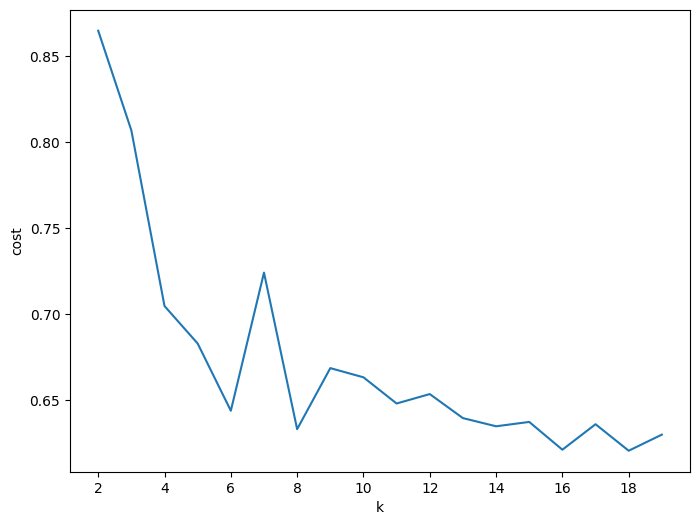

In [33]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(range(2, 20), cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()


In [34]:
k = 3
kmeans = KMeans().setK(k).setSeed(1)
model = kmeans.fit(scaledData)
predictions = model.transform(scaledData)
predictions.show(5,False)

+----------+-------------------+---------------------------------------------------------------+----------+
|CustomerID|rfm                |features                                                       |prediction|
+----------+-------------------+---------------------------------------------------------------+----------+
|16503     |[106.0,5.0,1421.43]|[0.28418230563002683,0.016194331983805668,0.02011814573186342] |2         |
|17420     |[50.0,3.0,598.83]  |[0.13404825737265416,0.008097165991902834,0.017219387148308358]|0         |
|15727     |[16.0,7.0,5178.96] |[0.04289544235924933,0.024291497975708502,0.033359298589225005]|0         |
|16861     |[59.0,3.0,151.65]  |[0.1581769436997319,0.008097165991902834,0.01564357039241953]  |0         |
|17389     |[0.0,43.0,31300.08]|[0.0,0.1700404858299595,0.12540746393334334]                   |0         |
+----------+-------------------+---------------------------------------------------------------+----------+
only showing top 5 rows



#### Statistical summary

In [35]:
results = rfm.join(predictions.select('CustomerID', 'prediction'), 'CustomerID', how='left')
results.show(5)

+----------+-------+---------+--------+----------+
|CustomerID|Recency|Frequency|Monetary|prediction|
+----------+-------+---------+--------+----------+
|     16503|    106|        5| 1421.43|         2|
|     17420|     50|        3|  598.83|         0|
|     15727|     16|        7| 5178.96|         0|
|     16861|     59|        3|  151.65|         0|
|     17389|      0|       43|31300.08|         0|
+----------+-------+---------+--------+----------+
only showing top 5 rows



In [36]:
results.groupBy('prediction')\
       .agg({'Recency':'mean',
             'Frequency': 'mean',
             'Monetary': 'mean'} )\
        .sort(F.col('prediction')).show(5)

+----------+------------------+------------------+------------------+
|prediction|      avg(Recency)|     avg(Monetary)|    avg(Frequency)|
+----------+------------------+------------------+------------------+
|         0|30.966337980278816|2543.0355321319194| 6.514450867052023|
|         1|296.02403846153845| 407.1683173076924|1.5592948717948718|
|         2|154.40148698884758| 702.5096406443622| 2.550185873605948|
+----------+------------------+------------------+------------------+

